# **분석 목표 : 다음 분기에 어떤 게임을 설계할 것인가**
---

#### 분석 내용
##### 1. 지역에 따라서 선호하는 게임 장르 파악 -> 
##### 2. 연도별 게임의 트랜드 파악
##### 3. 

In [984]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [985]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [986]:
df = pd.read_csv('vgames2.csv')
df.head()

,Unnamed: 0,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,1,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,2,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,3,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,4,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,5,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


In [987]:
df.shape

(16598, 10)

## `step 1` : 데이터 정제

<br>

🚨 **data description**

- `Name` : 게임의 이름입니다.
- `Platform` : 게임이 지원되는 플랫폼의 이름입니다.
- `Year` : 게임이 출시된 연도입니다.
- `Genre` : 게임의 장르입니다.
- `Publisher` : 게임을 배급한 회사입니다.
- `NA_Sales` : 북미지역에서의 출고량입니다.
- `EU_Sales` : 유럽지역에서의 출고량입니다.
- `JP_Sales` : 일본지역에서의 출고량입니다.
- `Other_Sales` : 기타지역에서의 출고량입니다.

---
### 1-1. 데이터 품질의 문제 해결
---

In [988]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16598 entries, 0 to 16597
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   16598 non-null  int64  
 1   Name         16598 non-null  object 
 2   Platform     16598 non-null  object 
 3   Year         16327 non-null  float64
 4   Genre        16548 non-null  object 
 5   Publisher    16540 non-null  object 
 6   NA_Sales     16598 non-null  object 
 7   EU_Sales     16598 non-null  object 
 8   JP_Sales     16598 non-null  object 
 9   Other_Sales  16598 non-null  object 
dtypes: float64(1), int64(1), object(8)
memory usage: 1.3+ MB


In [989]:
df.shape

(16598, 10)

In [990]:
df_clean = df.copy()

---
##### 1-1-a. Unnamed: 0 컬럼 제거


In [991]:
# Unnamed: 0 (컬럼이 인덱스와 동일하여 의미 없다고 판단)
df_clean.drop('Unnamed: 0', axis = 1, inplace = True)
df_clean.columns

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales'],
      dtype='object')

In [992]:
# 이름을 기준으로 정렬
df_clean.sort_values(by = 'Name', inplace = True)
df_clean.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
12910,'98 Koshien,PS,1998.0,Sports,Magical Company,0.15,0.1,0.12,0.03
15930,.hack//G.U. Vol.1//Rebirth,PS2,2006.0,Role-Playing,Namco Bandai Games,0,0,0.17,0
7132,.hack//G.U. Vol.2//Reminisce,PS2,2006.0,Role-Playing,Namco Bandai Games,0.11,0.09,0,0.03
10647,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006.0,Role-Playing,Namco Bandai Games,0,0,0.16,0
13148,.hack//G.U. Vol.3//Redemption,PS2,2007.0,Role-Playing,Namco Bandai Games,0,0,0.17,0


---
##### 1-1-b. 결측치 해결

In [993]:
# 결측치 컬럼 확인
df_clean.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher       58
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [994]:
# Publisher column의 Unknown 값도 추후 분석에 방해가 될 수 있다고 판단하여 결측치 처리

df_clean.Publisher.replace('Unknown', np.nan, inplace = True)
df_clean.isnull().sum()

Name             0
Platform         0
Year           271
Genre           50
Publisher      261
NA_Sales         0
EU_Sales         0
JP_Sales         0
Other_Sales      0
dtype: int64

In [995]:
# 가설 : 게임의 이름이 같으면 출시연도, 장르, 배급사 등이 같다.
# 같은 이름을 가진 게임들을 활용하여 NaN 값을 대체할 수 있는지 여부 확인 함수

# NaN 값이 존재하는 column에 

# 1. 같은 이름을 가진 게임이 하나의 데이터를 갖고 있지만 NaN 값만 존재하는 경우나
# 2. 같은 이름을 가진 게임이 둘 이상의 데이터를 갖고 있는 경우

# 어떤 값을 NaN 값으로 대체해야할지 불분명해지기 때문에 대체가 아닌 제거 결정

def whether_sub_or_not (column):
    # 같은 이름을 가진 게임 이름
    df_dupname = df_clean[df_clean.Name.isin(df_clean[df_clean.Name.duplicated()].Name.unique())]
    dupname = df_dupname.Name.unique()

    ans = '대체 가능'
    for name in dupname:
        temp = df_clean[df_clean.Name == name]
        Y = temp[column].unique()

        if len(Y) == 1: # 같은 이름을 가진 게임의 데이터가 하나일 경우
            if pd.isnull(Y).sum() == 1: # 데이터가 모두 NaN 값인 경우 제거 결정
                ans = '대체 불가능, 제거 필요'
                break
            else:
                continue
        
        else: # 같은 이름을 가진 게임의 데이터가 둘 이상인 경우
            if pd.isnull(Y).sum() == 0: # 같은 이름을 가진 게임들이 다른 시기에 출시된 경우
                ans = '대체 불가능, 제거 필요'
                break
            else: 
                continue
    
    return ans

yearsub = whether_sub_or_not('Year')
genresub  = whether_sub_or_not('Genre')
Publishersub = whether_sub_or_not('Publisher')

print('Year column 결측치 대체 여부 :', yearsub)
print('Genre column 결측치 대체 여부 :', genresub)
print('Publisher column 결측치 대체 여부 :', Publishersub)

Year column 결측치 대체 여부 : 대체 불가능, 제거 필요
Genre column 결측치 대체 여부 : 대체 불가능, 제거 필요
Publisher column 결측치 대체 여부 : 대체 불가능, 제거 필요


In [996]:
# 같은 이름을 가진 게임들이 플랫폼에 따라 다른 시기에 출시될 수 있거나 모든 Year값이 NaN인 경우를 파악하여
# 결측치를 대체할 수 있는지 가능성 파악

# 같은 이름을 가진 게임 데이터베이스
df_dupname = df_clean[df_clean.Name.isin(df_clean[df_clean.Name.duplicated()].Name.unique())]

dupname = df_dupname.Name.unique()

ans = []
for name in dupname:
    temp = df_clean[df_clean.Name == name]
    Y = temp.Publisher.unique()

    if len(Y) == 1: # 같은 이름을 가진 게임의 출시연도가 하나일 경우
        if pd.isnull(Y).sum() == 1: # 출시연도 모두 NaN 값인 경우 
            ans.append(temp.Name.unique())
        else:
            continue
    
    else: # 같은 이름을 가진 게임의 출시연도가 둘 이상인 경우
        if pd.isnull(Y).sum() >= 1: # 같은 이름을 가진 게임의 출시년도가 둘 이상이지만 하나 이상의 NaN 값이 존재하는 경우
            continue
        else: # 같은 이름을 가진 게임들이 다른 시기에 출시된 경우
            ans.append(temp.Name.unique())
ans
# 결측치 대체 불가능

[array(['2 in 1 Combo Pack: Sonic Heroes / Super Monkey Ball Deluxe'],
       dtype=object),
 array(['428: Fuusa Sareta Shibuya de'], dtype=object),
 array(['4x4 EVO 2'], dtype=object),
 array(['50 Classic Games'], dtype=object),
 array(['7 Wonders of the Ancient World'], dtype=object),
 array(["A Bug's Life"], dtype=object),
 array(['AMF Bowling Pinbusters!'], dtype=object),
 array(['ATV Quad Kings'], dtype=object),
 array(['ATV: Quad Power Racing'], dtype=object),
 array(['Abunai: Koi no Sousa Shitsu'], dtype=object),
 array(['Agatha Christie: The ABC Murders'], dtype=object),
 array(["Akiba's Trip: Undead & Undressed"], dtype=object),
 array(['Alan Wake'], dtype=object),
 array(['Alien Hominid'], dtype=object),
 array(['All-Star Baseball 2005'], dtype=object),
 array(['Alvin and the Chipmunks'], dtype=object),
 array(['Amagami'], dtype=object),
 array(["America's Next Top Model"], dtype=object),
 array(['American Chopper 2: Full Throttle'], dtype=object),
 array(['Apache: Air Assaul

In [997]:
df_clean[df_clean.Name == 'Zoo Hospital']

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
13611,Zoo Hospital,DS,2007.0,Simulation,Eidos Interactive,0.03,0,0,0
5017,Zoo Hospital,Wii,2008.0,Simulation,Majesco Entertainment,0.14,0.01,0,10K


In [998]:
df_clean.columns

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales'],
      dtype='object')

In [999]:
# 결측치 제거

df_clean.dropna(inplace = True)
df_clean.isnull().sum()


Name           0
Platform       0
Year           0
Genre          0
Publisher      0
NA_Sales       0
EU_Sales       0
JP_Sales       0
Other_Sales    0
dtype: int64

---
##### 1-1-c. 중복값

In [1000]:
# 중복값 없음

df_clean.duplicated().sum()

0

---
##### 1-1-d. 데이터타입 변환

In [1001]:
# Year column : float -> int
# Na_Sales ~ Other_sales : object -> float

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16142 entries, 12910 to 215
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Name         16142 non-null  object 
 1   Platform     16142 non-null  object 
 2   Year         16142 non-null  float64
 3   Genre        16142 non-null  object 
 4   Publisher    16142 non-null  object 
 5   NA_Sales     16142 non-null  object 
 6   EU_Sales     16142 non-null  object 
 7   JP_Sales     16142 non-null  object 
 8   Other_Sales  16142 non-null  object 
dtypes: float64(1), object(8)
memory usage: 1.2+ MB


(1) Year column : float -> int

In [1002]:
df_clean.Year.value_counts()

2009.0    1417
2008.0    1411
2010.0    1228
2007.0    1190
2011.0    1081
2006.0     996
2005.0     929
2002.0     820
2003.0     766
2004.0     735
2012.0     644
2015.0     600
2014.0     575
2013.0     541
2001.0     475
1998.0     373
2000.0     345
1999.0     336
2016.0     333
1997.0     287
1996.0     259
1995.0     215
1994.0     120
1993.0      60
1981.0      45
1992.0      43
1991.0      41
1982.0      36
1986.0      20
1983.0      17
1989.0      17
1987.0      16
1990.0      16
1988.0      15
1985.0      14
1984.0      14
11.0        10
8.0         10
9.0         10
1980.0       8
3.0          7
6.0          7
10.0         7
15.0         5
16.0         5
5.0          4
4.0          4
95.0         4
7.0          3
2017.0       3
96.0         3
2.0          3
98.0         3
0.0          3
14.0         2
1.0          2
12.0         2
97.0         2
13.0         2
2020.0       1
86.0         1
94.0         1
Name: Year, dtype: int64

In [1003]:
df_clean[df_clean.Year == 86]

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
4365,Adventure Island,NES,86.0,Platform,Hudson Soft,0,0,1.05,0


In [1004]:
# 86, 13 등 데이터를 1986, 2013 등으로 변화

year_idx = df_clean.Year[df_clean.Year < 100].index

for idx in year_idx:
    temp = df_clean.loc[idx, 'Year']

    if temp <= 20: # 2000 ~ 2015년
        temp += 2000

    else: # 1900년대
        temp +=  1900 

    df_clean.loc[idx, 'Year'] = temp

df_clean.Year.value_counts()

2009.0    1427
2008.0    1421
2010.0    1235
2007.0    1193
2011.0    1091
2006.0    1003
2005.0     933
2002.0     823
2003.0     773
2004.0     739
2012.0     646
2015.0     605
2014.0     577
2013.0     543
2001.0     477
1998.0     376
2000.0     348
2016.0     338
1999.0     336
1997.0     289
1996.0     262
1995.0     219
1994.0     121
1993.0      60
1981.0      45
1992.0      43
1991.0      41
1982.0      36
1986.0      21
1983.0      17
1989.0      17
1987.0      16
1990.0      16
1988.0      15
1984.0      14
1985.0      14
1980.0       8
2017.0       3
2020.0       1
Name: Year, dtype: int64

In [1005]:
# Year column : float -> int
df_clean.Year = df_clean.Year.astype('int')

(2) # Na_Sales ~ Other_sales : object -> float

In [1006]:
# 북미 매출 상위 10개 데이터로 검색, Grand Theft Auto V 를 참고하여 검색결과 
# Sales column들의 기본단위는 M, 화폐단위는 달러
# 데이터는 출시 후 총매출임을 파악

df_clean.sort_values(by = 'NA_Sales', ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
13057,Mark Davis Pro Bass Challenge,PS2,2002,Sports,Natsume,90K,0.07,0,0.02
13798,King of Clubs: Mini Golf,Wii,2008,Sports,Oxygen Interactive,90K,0,0,0.01
14347,Animal Planet: Vet Life,Wii,2009,Simulation,Activision,90K,0,0,0.01
10650,Mario Kart DS,DS,2005,Racing,Nintendo,9.81,7.57,4.13,1.92
6248,Call of Duty: Black Ops,X360,2010,Shooter,Activision,9.67,3.73,0.11,1.13
10913,Grand Theft Auto V,X360,2013,Action,Take-Two Interactive,9.63M,5.31,0.06,1.38
14856,Super Mario Bros. 3,NES,1988,Platform,Nintendo,9.54,3.44,3.84,0.46
14669,Grand Theft Auto: San Andreas,PS2,2004,Action,Take-Two Interactive,9.43,0.4,0.41,10.57
10899,Wii Fit Plus,Wii,2009,Sports,Nintendo,9.09,8.59,2.53,1.79
11137,Nintendogs,DS,2005,Simulation,Nintendo,9.07,11,1.93,2.75


In [1007]:
# 숮자 외 다른 문자가 섞였는지 확인 -> K, M

for i in range(-4, 0):
    print(df_clean.iloc[:, i].str.extract(r'([^0-9])').value_counts())

.    11689
K       94
M       29
dtype: int64
.    10509
K       97
M       31
dtype: int64
.    5993
K      98
M      60
dtype: int64
.    9843
K      95
M      40
dtype: int64


In [1008]:
# Sales column들을 str에서 float로 데이터타입 변환하는 함수
# 기본 단위를 M(1000000)으로 설정

def str_to_float (data):
           
    if 'K' in data:
        K_contain = data.replace('K', '')
        K_contain = float(K_contain) / 1000
        return K_contain
            
    elif 'M' in data:
        M_contain = data.replace('M', '')
        M_contain = float(M_contain)
        return M_contain

    else:
        return float(data)
                
# Sales column에 함수 적용
for idx in range(-4, 0):
    df_clean.iloc[:, idx] = df_clean.iloc[:, idx].apply(str_to_float)

/var/folders/_8/qgs27d456t3f7jzjt6dj6b140000gn/T/ipykernel_30677/2008463039.py:21: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_clean.iloc[:, idx] = df_clean.iloc[:, idx].apply(str_to_float)


In [1009]:
df_clean.sort_values(by = 'NA_Sales', ascending = False).head(10)

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
2908,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46
4199,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77
10488,Duck Hunt,NES,1984,Shooter,Nintendo,26.93,0.63,0.28,0.47
1203,Tetris,GB,1989,Puzzle,Nintendo,23.20,2.26,4.22,0.58
12579,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31
3352,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96
4343,Kinect Adventures!,X360,2010,Misc,Microsoft Game Studios,14.97,4.94,0.24,1.67
16531,New Super Mario Bros. Wii,Wii,2009,Platform,Nintendo,14.59,7.06,4.70,2.26
3014,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85
13111,Super Mario World,SNES,1990,Platform,Nintendo,12.78,3.75,3.54,0.55


In [1010]:
# sales column 명에 $1K 가 기본 단위임을 표기

for col_name in df_clean.columns[-4:]:
    new_col_name = col_name + ' ($1M)'
    df_clean.rename({col_name : new_col_name}, axis = 'columns', inplace = True)

df_clean.columns



Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales ($1M)',
       'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)'],
      dtype='object')

In [1011]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16142 entries, 12910 to 215
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Name               16142 non-null  object 
 1   Platform           16142 non-null  object 
 2   Year               16142 non-null  int64  
 3   Genre              16142 non-null  object 
 4   Publisher          16142 non-null  object 
 5   NA_Sales ($1M)     16142 non-null  float64
 6   EU_Sales ($1M)     16142 non-null  float64
 7   JP_Sales ($1M)     16142 non-null  float64
 8   Other_Sales ($1M)  16142 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 1.7+ MB


---
##### 1-1-e. year 범위 설정

In [1012]:
df_clean = df_clean[df_clean.Year <= 2015]

In [1013]:
# 본 데이터는 1980년부터 2015년까지임
print(df_clean.Year.min())
print(df_clean.Year.max())

1980
2015


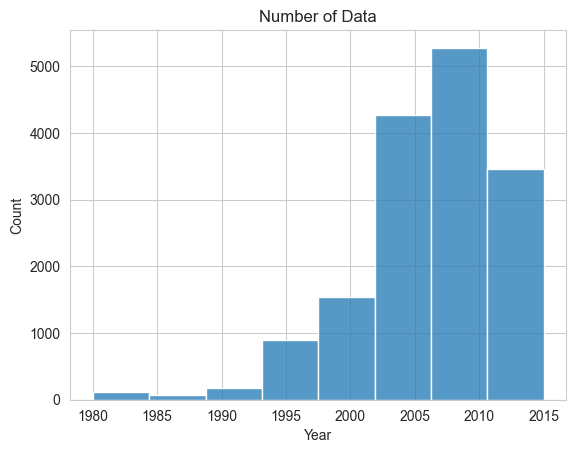

In [1014]:
# 효율적인 분석을 위하여 수가 적고 오래된 1995년 이전 데이터는 제외하고자 함 (20년 간 데이터 사용)
sns.histplot(df_clean.Year, bins = 8);
plt.title('Number of Data')

df_clean = df_clean[(df_clean.Year > 1995) & (df_clean.Year <= 2015)]

In [1015]:
df_clean.shape

(15097, 9)

---
### 1-2. 데이터 구조의 문제 해결
---

In [1016]:
# 본 데이터는 데이터 구조의 문제는 없는 것으로 보임

---
### 1-3. Feature Engineering
---

##### 1-3-a. 매출 총 합계(total sales) 컬럼 생성

In [1017]:
# 게임별 매출 총 합계를 알아보기 위해 Total Sales column 신규 생성

total_sales = df_clean['NA_Sales ($1M)'] + df_clean['EU_Sales ($1M)'] + df_clean['JP_Sales ($1M)'] + df_clean['Other_Sales ($1M)']
df_clean['Total_Sales ($1M)'] = total_sales

df_clean.columns


Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales ($1M)',
       'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)',
       'Total_Sales ($1M)'],
      dtype='object')

##### 1-3-b. 게임기 유형 나누기

In [1018]:
# Platform을 거치형 콘솔 게임기, 휴대용 콘솔 게임기, PC로 분류

# 거치형 콘솔(Home video game consoles) : PS, PS2, PS3, PS4, X360, XB, Xone, Wii, Wii U, N64, GC, DC
# 휴대형 콘솔(Handheld game consoles) : PSP, DS, 3DS, GBA, PSV, GB, WS
# PC : PC

def platform_classification (platform):
    if platform in ['PS', 'PS2', 'PS3', 'PS4', 'X360', 'XB', 'Xone', 'Wii', 'WiiU', 'N64', 'GC', 'DC']:
        return 'Home console'
    
    elif platform in ['PSP', 'DS', '3DS', 'GBA', 'PSV', 'GB', 'WS']:
        return 'Handheld console'

    else:
        return 'PC'

df_clean['Platform_Type'] = df_clean.Platform.apply(platform_classification)
df_clean.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales ($1M),EU_Sales ($1M),JP_Sales ($1M),Other_Sales ($1M),Total_Sales ($1M),Platform_Type
12910,'98 Koshien,PS,1998,Sports,Magical Company,0.15,0.10,0.12,0.03,0.40,Home console
15930,.hack//G.U. Vol.1//Rebirth,PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17,Home console
7132,.hack//G.U. Vol.2//Reminisce,PS2,2006,Role-Playing,Namco Bandai Games,0.11,0.09,0.00,0.03,0.23,Home console
10647,.hack//G.U. Vol.2//Reminisce (jp sales),PS2,2006,Role-Playing,Namco Bandai Games,0.00,0.00,0.16,0.00,0.16,Home console
13148,.hack//G.U. Vol.3//Redemption,PS2,2007,Role-Playing,Namco Bandai Games,0.00,0.00,0.17,0.00,0.17,Home console


---
### 1-4. 이상치 확인
---

In [1019]:
# 본 데이터는 이상치가 없어보임

df_clean.describe()

,Year,NA_Sales ($1M),EU_Sales ($1M),JP_Sales ($1M),Other_Sales ($1M),Total_Sales ($1M)
count,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000,15097.000000
mean,2006.885805,0.258557,0.150642,0.065469,0.050207,0.524874
std,4.670581,0.732350,0.518935,0.278836,0.195404,1.502905
min,1996.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2004.000000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,2010.000000,0.240000,0.120000,0.030000,0.040000,0.470000
max,2015.000000,41.490000,29.020000,10.220000,10.570000,82.740000


In [1020]:
df_clean.columns

Index(['Name', 'Platform', 'Year', 'Genre', 'Publisher', 'NA_Sales ($1M)',
       'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)',
       'Total_Sales ($1M)', 'Platform_Type'],
      dtype='object')

___
### 1-5. 마무리
---

In [1021]:
# 인덱스 정리 및 컬럼 순서 조정

df_clean = df_clean.reset_index(drop = True)
df_clean= df_clean[['Name', 'Platform', 'Platform_Type', 'Year', 'Genre', 'Publisher', 'NA_Sales ($1M)',
       'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)',
       'Total_Sales ($1M)']]

df_clean.columns



Index(['Name', 'Platform', 'Platform_Type', 'Year', 'Genre', 'Publisher',
       'NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)',
       'Other_Sales ($1M)', 'Total_Sales ($1M)'],
      dtype='object')

In [1022]:
# df_clean을 df로 대체

df = df_clean
del df_clean

In [1023]:
df.shape

(15097, 11)

## `step 2` : EDA 및 시각화

<br>

🚨 **분석 내용**

- `시장 규모 파악`
- `연도별, 장르별 지역들의 매출 파악` 
- `연도별, 플랫폼별 선호 플랫폼(매출 기준)`
- `연도별 트렌드(장르, 플랫폼)`

- 지역 선정 가설 : 북미와 유럽의 선호는 동일할 것이다

In [1024]:
df.Genre.unique()

array(['Sports', 'Role-Playing', 'Action', 'Racing', 'Shooter', 'Misc',
       'Adventure', 'Puzzle', 'Simulation', 'Platform', 'Strategy',
       'Fighting'], dtype=object)

---
### 2-1. 연도별 시장 규모 파악
##### 지역 구분 : 북미, 유럽, 일본, 그 외 지역 (지역은 주어진 매출 데이터로 구분)
---

#### 연도별 시장 규모 파악 결과

##### - 북미, 유럽, 일본과 그 외 지역 순으로 시장 규모 순위가 정해짐
##### - 전세계 PC 및 콘솔게임 시장이 2010년대에 들어서며 침체되고 있음 (모바일 게임 시장 확대?)
##### - 특히 북미 시장의 침체가 가장 눈에 띔


In [1025]:
# 1996년부터 2015년까지 연도별 매출 데이터 5년씩 나누기
temp = df.groupby(['Year'], as_index = False)[['NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)', 'Total_Sales ($1M)']].sum()
df_temp = pd.DataFrame(data = temp)
years = [1995, 2000, 2005, 2010, 2015]
labels = ['1996~2000', '2001~2005', '2006~2010', '2011~2015']
cuts = pd.cut(df_temp.Year, bins = years, labels = labels)
df_temp['Year'] = cuts

sales_Total = df_temp.groupby(['Year'], as_index = False)[['NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)', 'Total_Sales ($1M)']].sum()
df_sales_Total = pd.DataFrame(data = sales_Total)
df_sales_Total


,Year,NA_Sales ($1M),EU_Sales ($1M),JP_Sales ($1M),Other_Sales ($1M),Total_Sales ($1M)
0,1996~2000,528.48,276.61,250.48,49.28,1104.85
1,2001~2005,1036.45,532.44,209.62,162.79,1941.30
2,2006~2010,1562.21,837.09,309.10,345.66,3054.06
3,2011~2015,776.29,628.10,219.18,200.24,1823.81


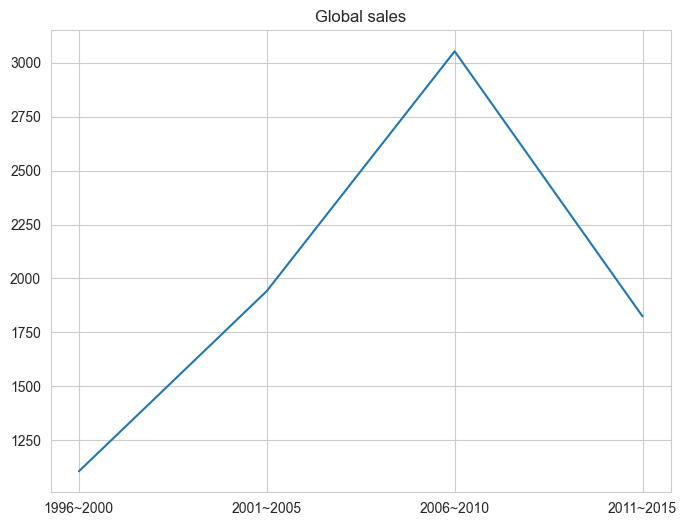

In [1026]:
# 글로벌 시장 매출

plt.figure(figsize = (8, 6))
plt.plot('Year', 'Total_Sales ($1M)', data = df_sales_Total)
plt.title('Global sales')
plt.show()

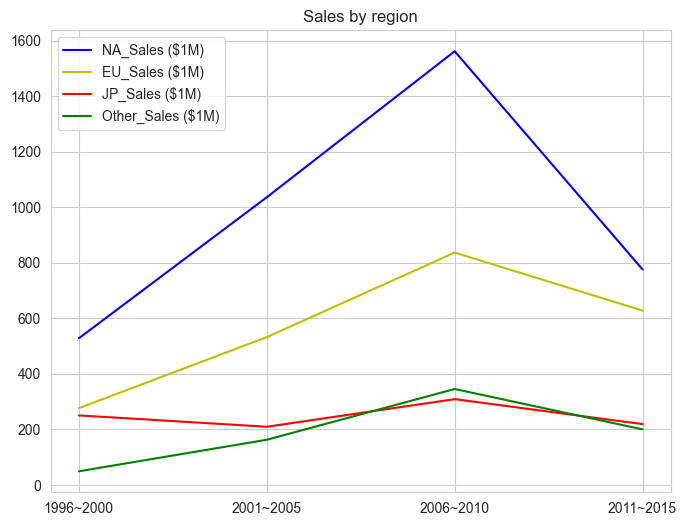

In [1027]:
# 지역별 시장 매출

plt.figure(figsize = (8, 6))
plt.plot('Year','NA_Sales ($1M)', 'b',data = df_sales_Total)
plt.plot('Year','EU_Sales ($1M)', 'y',data = df_sales_Total)
plt.plot('Year','JP_Sales ($1M)', 'r',data = df_sales_Total)
plt.plot('Year','Other_Sales ($1M)', 'g',data = df_sales_Total)
plt.title('Sales by region')
plt.legend()
plt.show()

---
### 2-2. 연도별, 장르별 지역들의 매출 파악
---

#### 연도별, 지역별 게임 장르 선호도 조사 결과

##### - 전 세계적으로 Sports 장르는 2006년부터 2010년을 기점으로 상승세가 꺾임
##### - **일본**이 나머지 세계 시장과 다른 장르 선호도가 보임

        - 세계 시장은 Action, Shooter, Sports 순으로 장르 선호도가 보였으나

        - 일본 시장만 Role-Playing, Action, Misc 순으로 선호를 보임

        - 다만, 일본 시장도 Action 장르의 매출이 상승하고 있어 세계적인 트렌드를 따라가고 있다고 판단됨

##### - 일본을 제외한 나머지 북미, 유럽 등의 시장에서는 Shooter 장르의 성장세가 돋보임
##### - 유럽은 Shooter는 물론, Action 장르에서도 가파른 성장세를 보여주며 Action 장르의 선호도가 꺾인 다른 시장들과는 차별점을 보여줌

In [1028]:
# 년도를 5년씩 나누는 함수 생성

def split_5years (column):
    temp = df.groupby(['Year', column], as_index = False)[['NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)', 'Total_Sales ($1M)']].sum()
    df_temp = pd.DataFrame(data = temp)
    years = [1995, 2000, 2005, 2010, 2015]
    labels = ['1996~2000', '2001~2005', '2006~2010', '2011~2015']
    cuts = pd.cut(df_temp.Year, bins = years, labels = labels)
    df_temp['Year'] = cuts

    res = df_temp.groupby(['Year', column], as_index = False)[['NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)', 'Total_Sales ($1M)']].sum()
    df_res = pd.DataFrame(data = res)

    return df_res

In [1029]:
df_genre_Total = split_5years('Genre')

pd.pivot_table(data = df_genre_Total, index = 'Year', columns = 'Genre').T

Year                            1996~2000  2001~2005  2006~2010  2011~2015
                  Genre                                                   
EU_Sales ($1M)    Action            47.10     104.39     154.53     192.59
                  Adventure          7.93      10.82      24.61      13.37
                  Fighting          23.46      25.58      26.97      15.40
                  Misc              15.20      43.30     105.13      40.43
                  Platform          31.45      53.78      52.64      29.13
                  Puzzle             3.79      10.95      24.90       3.42
                  Racing            42.75      70.43      74.00      39.85
                  Role-Playing      35.87      40.91      49.83      54.27
                  Shooter           15.90      52.76      92.23     134.84
                  Simulation         7.21      34.36      50.80      18.22
                  Sports            36.26      77.94     164.90      79.21
                  Strategy           9.69       7.22      16.55       7.37
JP_Sales ($1M)    Action            16.71      25.33      37.10      55.77
                  Adventure          8.78       6.70      17.15      10.71
                  Fighting          18.78      13.23      16.20      11.59
                  Misc              14.42      18.13      44.41      16.38
                  Platform          17.98      17.39      23.07      11.96
                  Puzzle             8.03      10.27       9.52       2.91
                  Racing            15.90      12.98       7.56       5.60
                  Role-Playing      75.48      55.53      88.16      67.54
                  Shooter            4.13       3.73       7.43      10.81
                  Simulation        19.04      15.58      11.67      11.24
                  Sports            30.92      20.55      37.88      10.14
                  Strategy          20.31      10.20       8.95       4.53
NA_Sales ($1M)    Action            77.77     202.40     300.87     220.06
                  Adventure         10.72      19.39      47.32      14.00
                  Fighting          49.78      56.78      63.05      29.50
                  Misc              31.47      68.42     214.62      69.46
                  Platform          62.54     114.96      97.25      37.52
                  Puzzle             8.64      19.40      40.41       2.80
                  Racing            78.56     127.10     101.33      30.99
                  Role-Playing      51.12      75.46     115.04      71.25
                  Shooter           35.66     117.49     178.82     176.92
                  Simulation        14.63      53.39      93.21      15.19
                  Sports            85.87     167.29     289.17     101.24
                  Strategy          21.72      14.37      21.12       7.36
Other_Sales ($1M) Action             7.53      39.92      70.32      63.11
                  Adventure          1.33       2.22       8.32       4.28
                  Fighting           4.07       7.66      16.37       6.31
                  Misc               2.50      11.75      45.21      12.64
                  Platform           4.80      11.95      20.85       7.93
                  Puzzle             0.85       2.67       6.69       0.69
                  Racing             6.53      27.81      29.80      10.56
                  Role-Playing       7.71       7.96      20.70      17.82
                  Shooter            2.23      14.06      37.47      44.28
                  Simulation         2.03       8.41      16.72       3.75
                  Sports             7.61      26.69      68.19      26.93
                  Strategy           2.09       1.69       5.02       1.94
Total_Sales ($1M) Action           149.11     372.04     562.82     531.53
                  Adventure         28.76      39.13      97.40      42.36
                  Fighting          96.09     103.25     122.59      62.80
                  Misc   

/var/folders/_8/qgs27d456t3f7jzjt6dj6b140000gn/T/ipykernel_30677/1500590408.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_genre_Total.iloc[:-5:].corr(), annot = True)


Text(0.5, 1.0, 'Correlation of sales, classifedy by Genre')

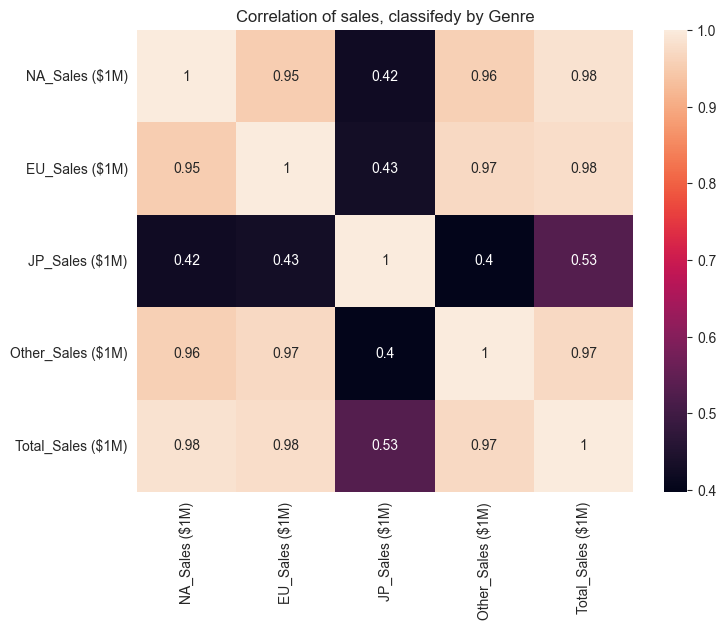

In [1030]:
plt.figure(figsize = (8, 6))
sns.heatmap(df_genre_Total.iloc[:-5:].corr(), annot = True)
plt.title('Correlation of sales, classifedy by Genre')

###

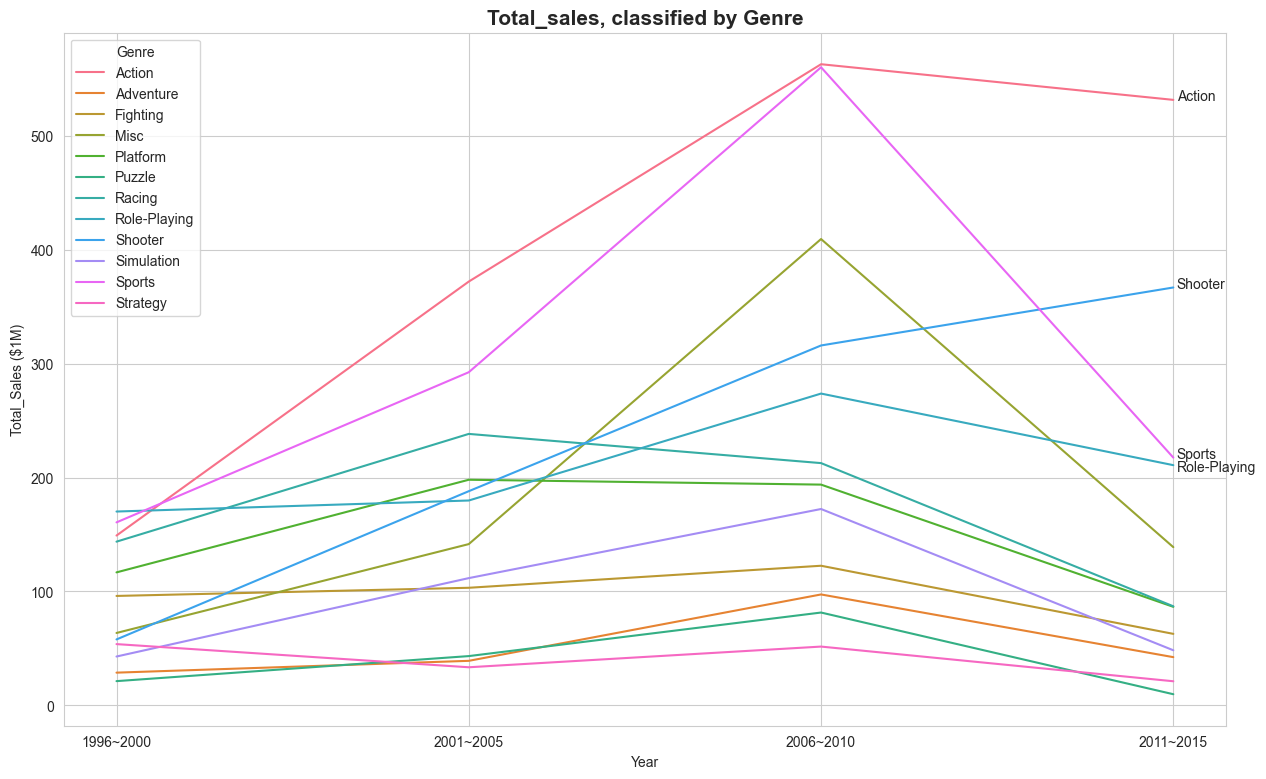

In [1031]:
# 글로벌 데이터

# 1996년부터 2015년까지 데이터 5년씩 나누기
df_genre_Total = split_5years('Genre')

# 시각화

plt.figure(figsize = (15, 9))
sns.set_style('whitegrid')
sns.lineplot(data = df_genre_Total, x = 'Year', y = 'Total_Sales ($1M)', hue = 'Genre')
plt.title('Total_sales, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('Action', (3.01, 531), fontsize = 10)
plt.annotate('Shooter', (3.01, 366), fontsize = 10)
plt.annotate('Sports', (3.01, 217), fontsize = 10)
plt.annotate('Role-Playing', (3.01, 205), fontsize = 10)
plt.show()

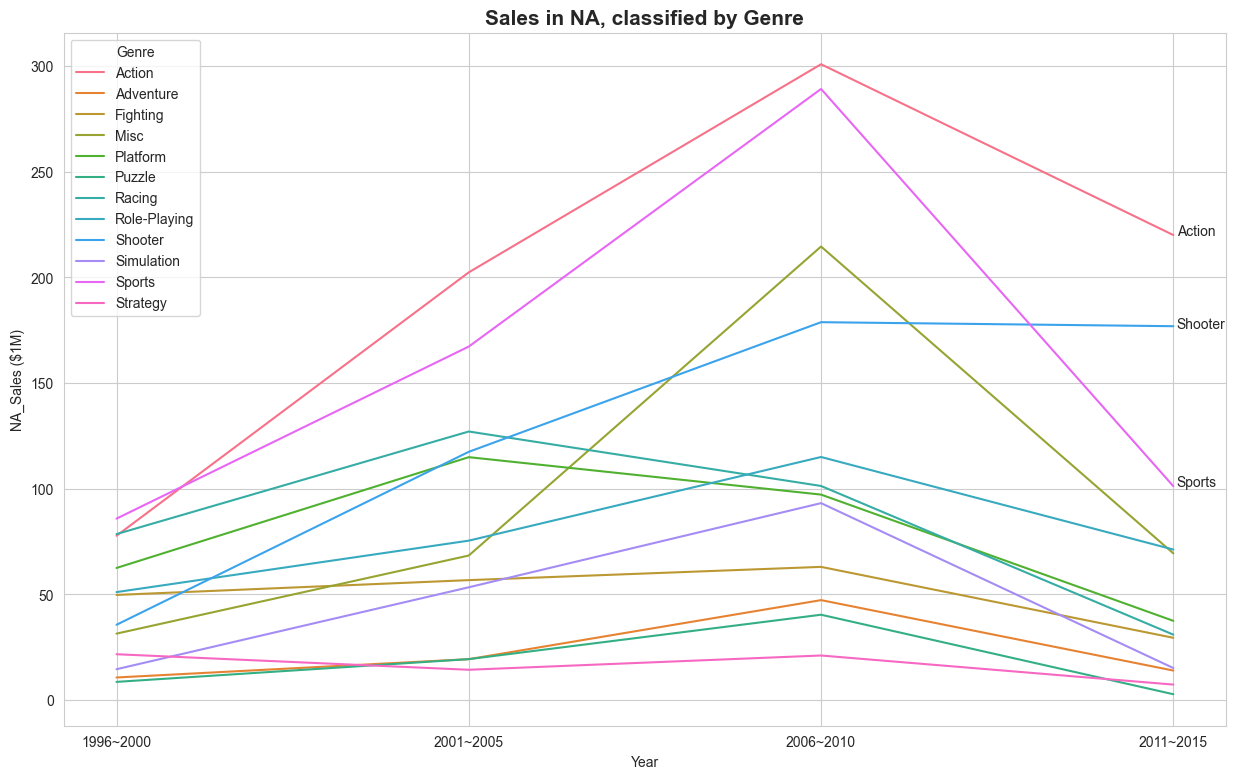

In [1032]:
# 북미 (NA) 데이터

# 시각화

plt.figure(figsize = (15, 9))
sns.set_style('whitegrid')
sns.lineplot(data = df_genre_Total, x = 'Year', y = 'NA_Sales ($1M)', hue = 'Genre')
plt.title('Sales in NA, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('Action', (3.01, 220), fontsize = 10)
plt.annotate('Shooter', (3.01, 176), fontsize = 10)
plt.annotate('Sports', (3.01, 101), fontsize = 10)
plt.show()

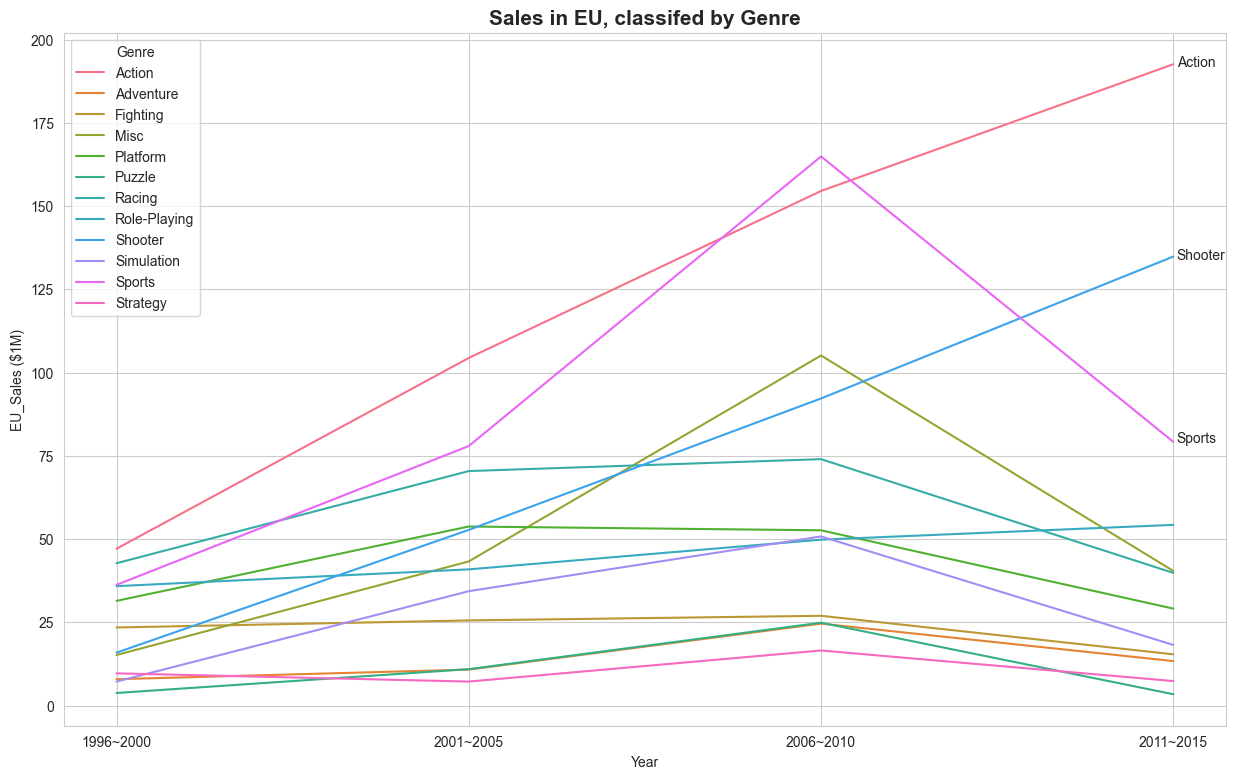

In [1033]:
# 유럽 (EU) 데이터

# 시각화

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_genre_Total, x = 'Year', y = 'EU_Sales ($1M)', hue = 'Genre')
plt.title('Sales in EU, classifed by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('Action', (3.01, 192), fontsize = 10)
plt.annotate('Shooter', (3.01, 134), fontsize = 10)
plt.annotate('Sports', (3.01, 79), fontsize = 10)
plt.show()

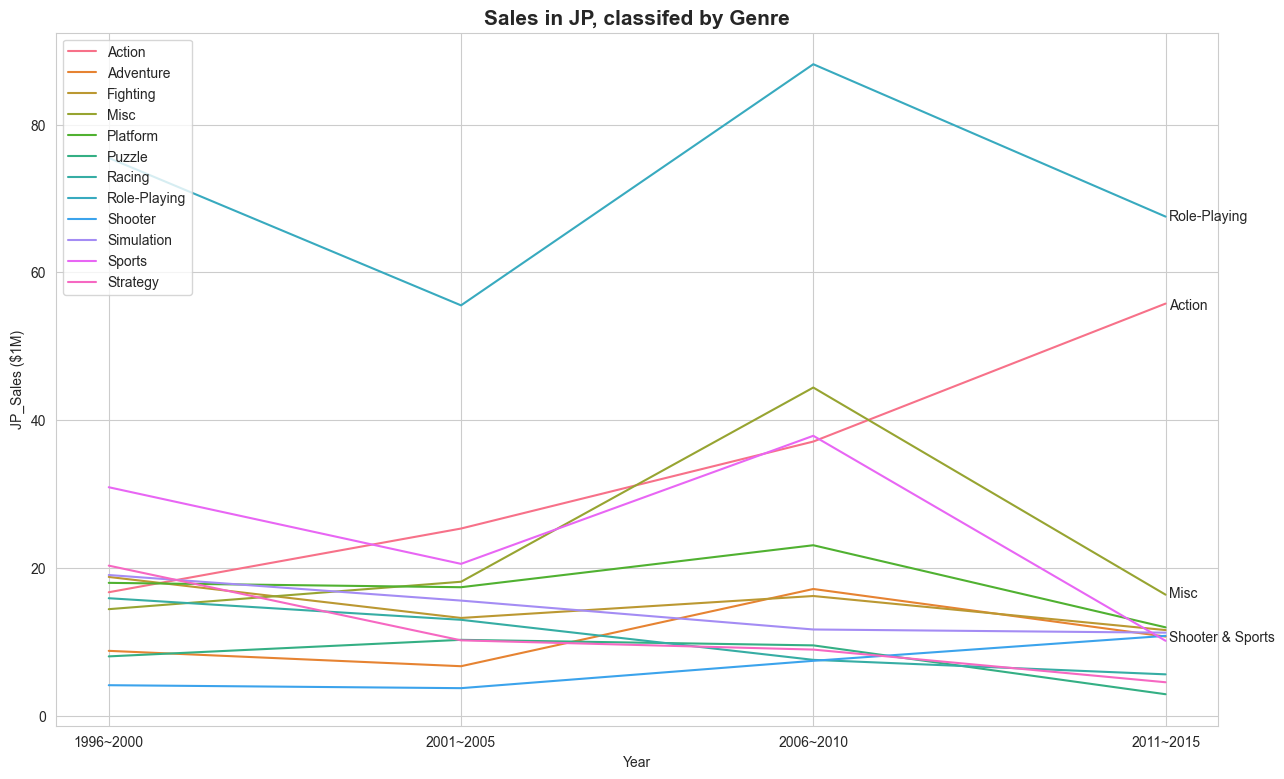

In [1034]:
# 일본 (JP) 데이터

# 시각화

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_genre_Total, x = 'Year', y = 'JP_Sales ($1M)', hue = 'Genre')
plt.title('Sales in JP, classifed by Genre', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Role-Playing', (3.01, 67), fontsize = 10)
plt.annotate('Action', (3.01, 55), fontsize = 10)
plt.annotate('Misc', (3.01, 16), fontsize = 10)
plt.annotate('Shooter & Sports', (3.01, 10), fontsize = 10)
plt.show()

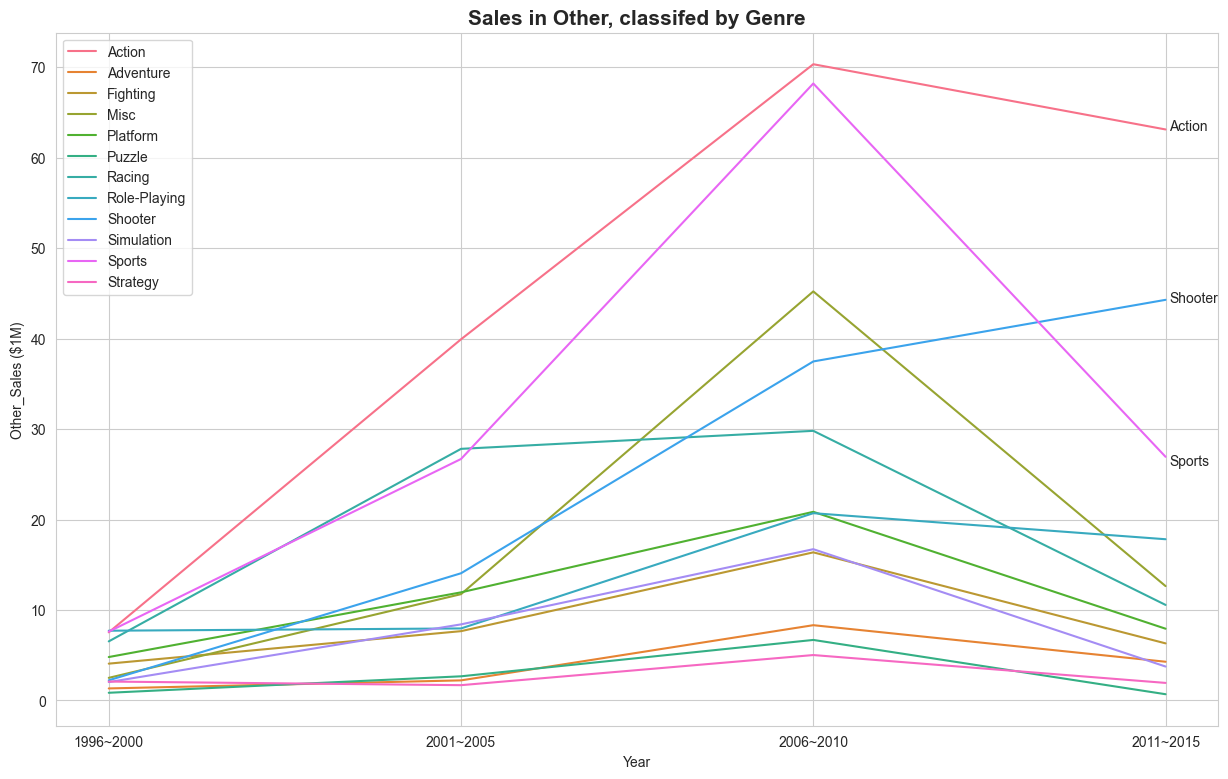

In [1035]:
# 그 외 지역 (Other) 데이터

# 시각화

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_genre_Total, x = 'Year', y = 'Other_Sales ($1M)', hue = 'Genre')
plt.title('Sales in Other, classifed by Genre', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Action', (3.01, 63), fontsize = 10)
plt.annotate('Shooter', (3.01, 44), fontsize = 10)
plt.annotate('Sports', (3.01, 26), fontsize = 10)
plt.show()



---
### 2-3. 연도별, 플랫폼별 지역들의 매출 파악
#### 플랫폼은 거치형 콘솔, 휴대용 콘솔, PC로 분류
---

#### 분석 결과

##### - 일본과 글로벌 추세가 다름
    - 글로벌 시장은 거치형 콘솔(Home console)이 가장 인기가 많고, 그 뒤를 휴대용 콘솔, PC가 따르고 있음
    - 일본 시장은 휴대용 콘솔이 가장 인기가 많고 그 다음이 거치형 콘솔임, PC 게임은 시장이 거의 없음

##### - 일본 시장을 제외하고 PC 게임의 성장은 주목할만 함, 유럽 지역에서는 2010년대에 들어 휴대용 콘솔보다 인기가 많아졌음

In [1036]:
# 1996년부터 2015년까지 데이터 5년씩 나누기

df_platform_Total = split_5years('Platform_Type')

pd.pivot_table(data = df_platform_Total, index = 'Year', columns = 'Platform_Type').T

Year                                1996~2000  2001~2005  2006~2010  2011~2015
                  Platform_Type                                               
EU_Sales ($1M)    Handheld console      29.72     129.82     192.86      81.41
                  Home console         236.68     383.10     601.67     453.97
                  PC                    10.21      19.52      42.56      92.72
JP_Sales ($1M)    Handheld console      46.97      88.57     180.62     136.56
                  Home console         170.33     120.97     128.48      82.29
                  PC                    33.18       0.08       0.00       0.33
NA_Sales ($1M)    Handheld console      46.84     258.70     392.80     109.93
                  Home console         455.65     761.34    1155.03     562.44
                  PC                    25.99      16.41      14.38     103.92
Other_Sales ($1M) Handheld console       4.74      27.43      78.03      23.75
                  Home console          43.50     133.60     259.34     153.47
                  PC                     1.04       1.76       8.29      23.02
Total_Sales ($1M) Handheld console     128.27     504.52     844.31     351.65
                  Home console         906.16    1399.01    2144.52    1252.17
                  PC                    70.42      37.77      65.23     219.99

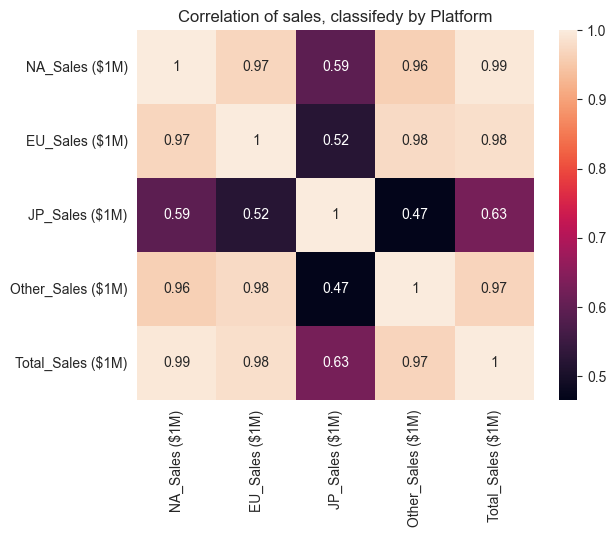

In [1037]:
sns.heatmap(df_platform_Total.iloc[:, -5:].corr(), annot = True)
plt.title('Correlation of sales, classifedy by Platform')
plt.show()

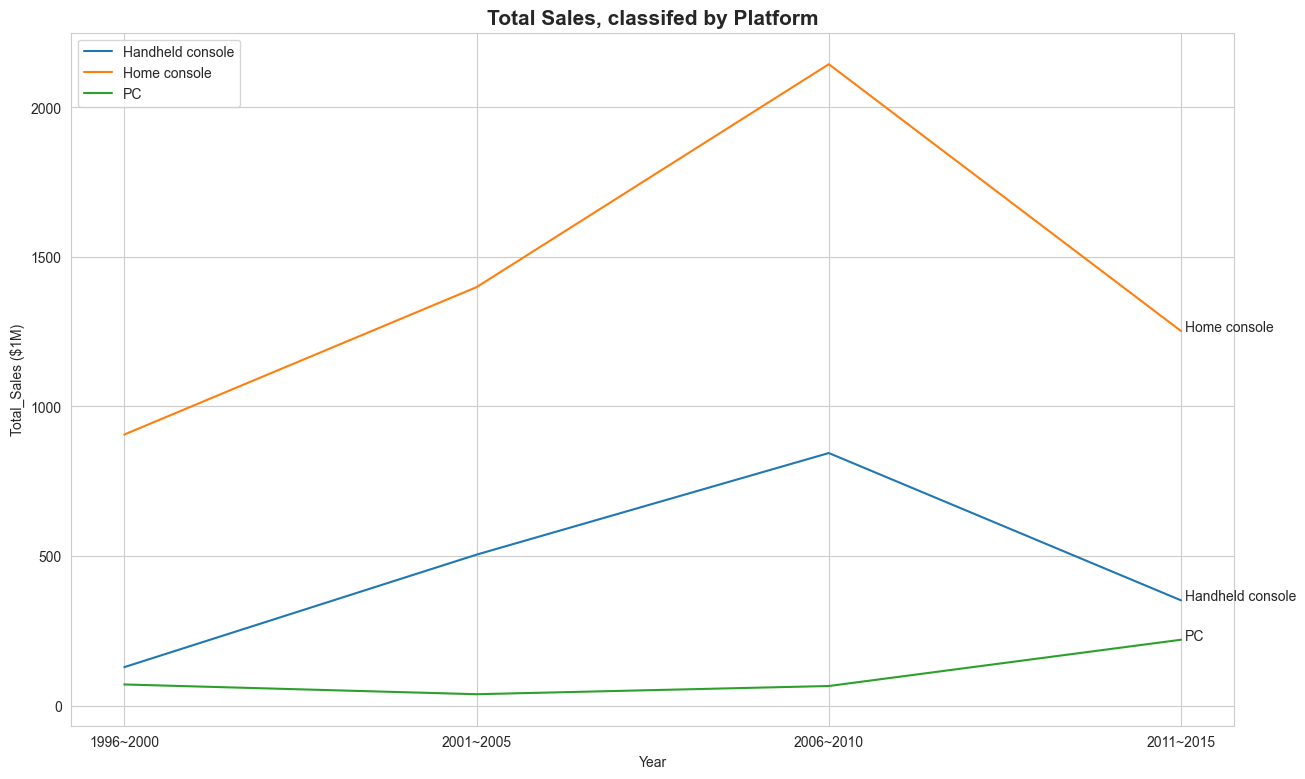

In [1038]:
# 글로벌 데이터

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_platform_Total, x = 'Year', y = 'Total_Sales ($1M)', hue = 'Platform_Type')
plt.title('Total Sales, classifed by Platform', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Home console', (3.01, 1252), fontsize = 10)
plt.annotate('Handheld console', (3.01, 350), fontsize = 10)
plt.annotate('PC', (3.01, 219), fontsize = 10)
plt.show()

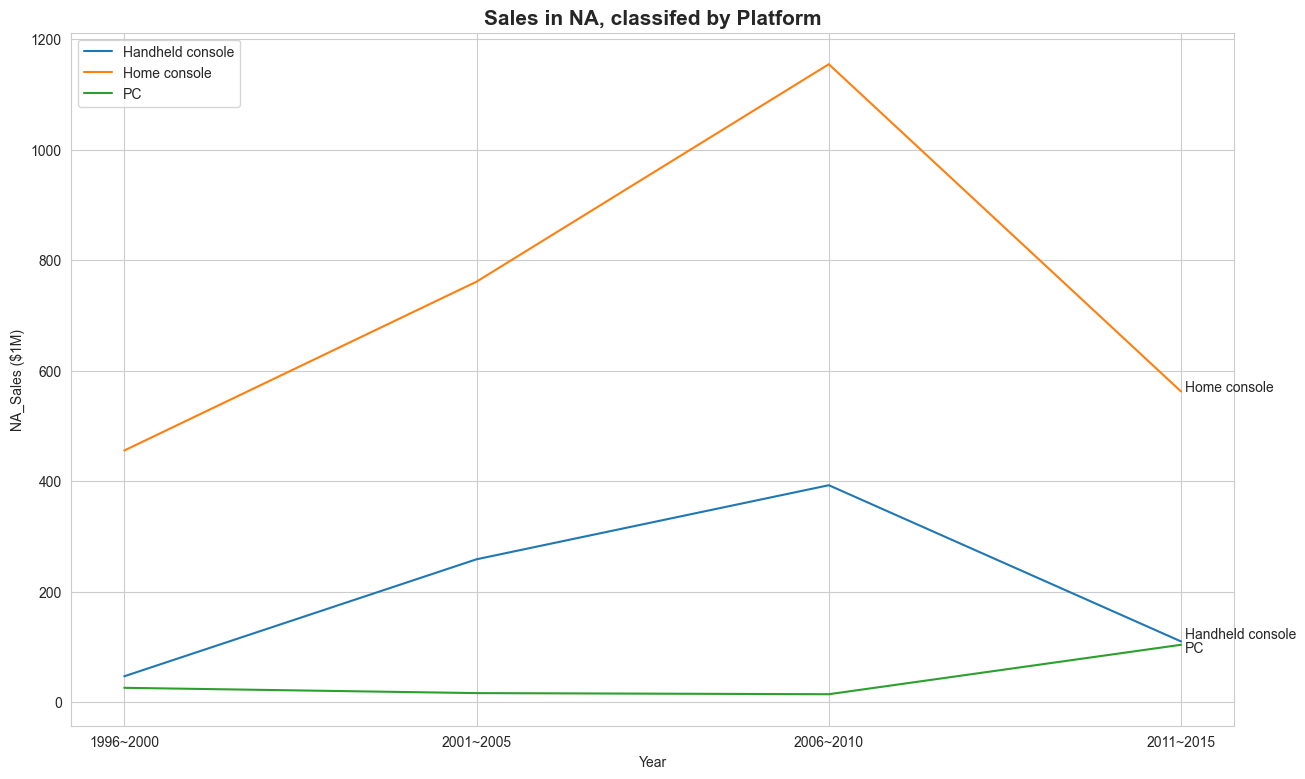

In [1039]:
# 북미 (NA) 데이터

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_platform_Total, x = 'Year', y = 'NA_Sales ($1M)', hue = 'Platform_Type')
plt.title('Sales in NA, classifed by Platform', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Home console', (3.01, 562), fontsize = 10)
plt.annotate('Handheld console', (3.01, 115), fontsize = 10)
plt.annotate('PC', (3.01, 90), fontsize = 10)
plt.show()

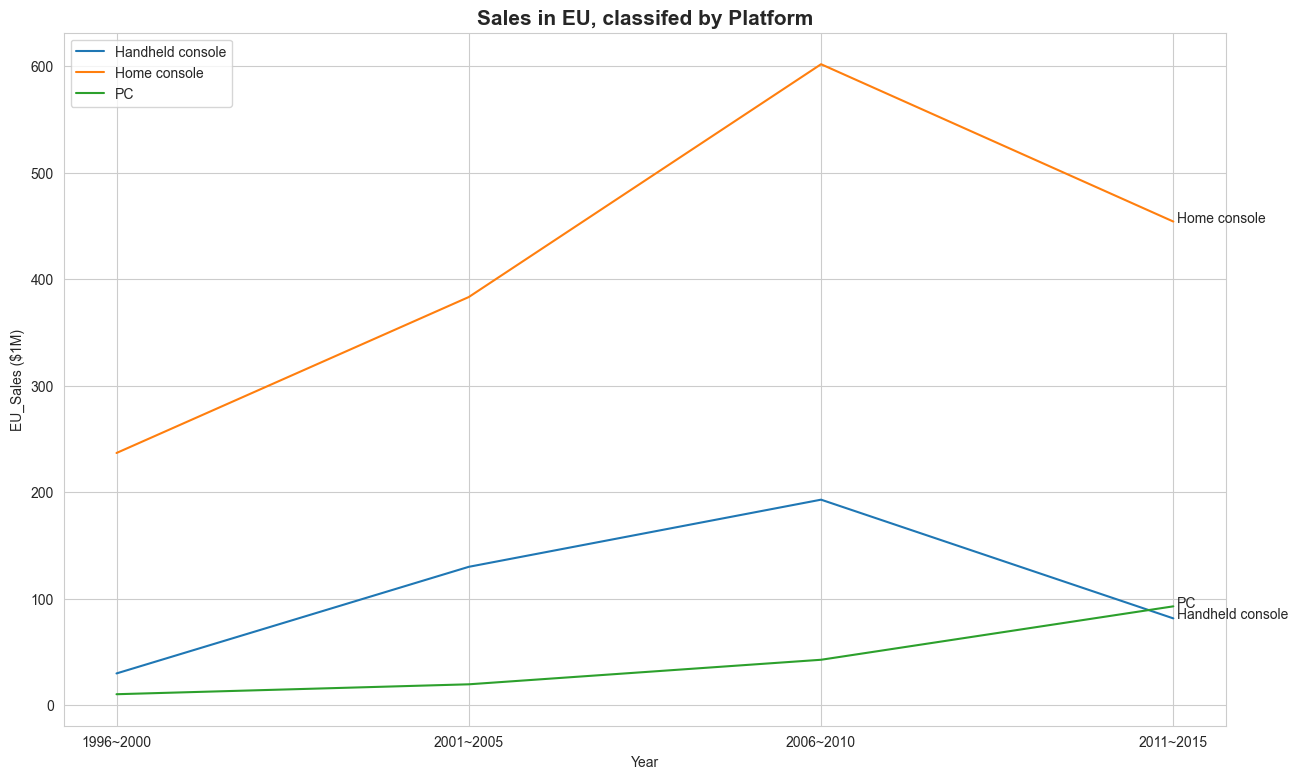

In [1040]:
# 유럽 (EU) 데이터

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_platform_Total, x = 'Year', y = 'EU_Sales ($1M)', hue = 'Platform_Type')
plt.title('Sales in EU, classifed by Platform', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Home console', (3.01, 453), fontsize = 10)
plt.annotate('Handheld console', (3.01, 81), fontsize = 10)
plt.annotate('PC', (3.01, 92), fontsize = 10)
plt.show()

Text(3.01, 0, 'PC')

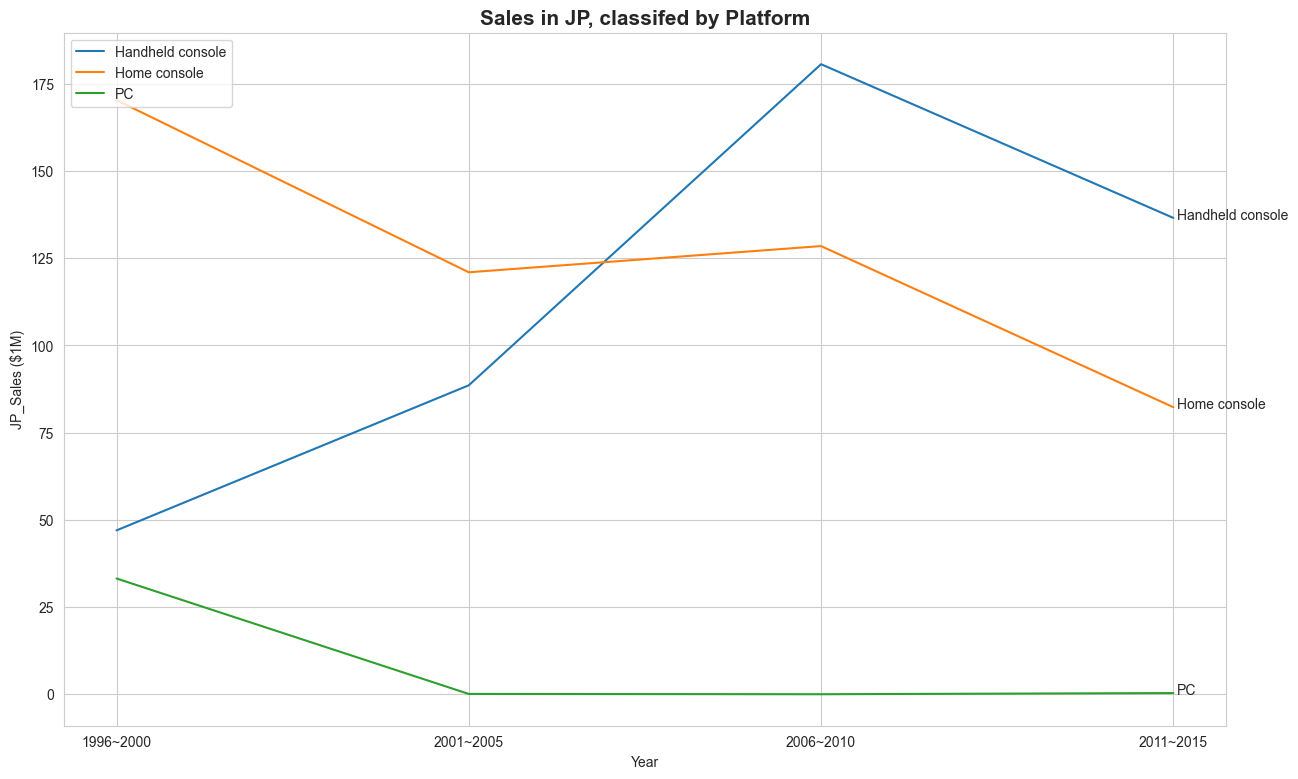

In [1041]:
# 일본 (JP) 데이터

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_platform_Total, x = 'Year', y = 'JP_Sales ($1M)', hue = 'Platform_Type')
plt.title('Sales in JP, classifed by Platform', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Home console', (3.01, 82), fontsize = 10)
plt.annotate('Handheld console', (3.01, 136), fontsize = 10)
plt.annotate('PC', (3.01, 0), fontsize = 10)

Text(3.01, 23, 'PC & Handheld console')

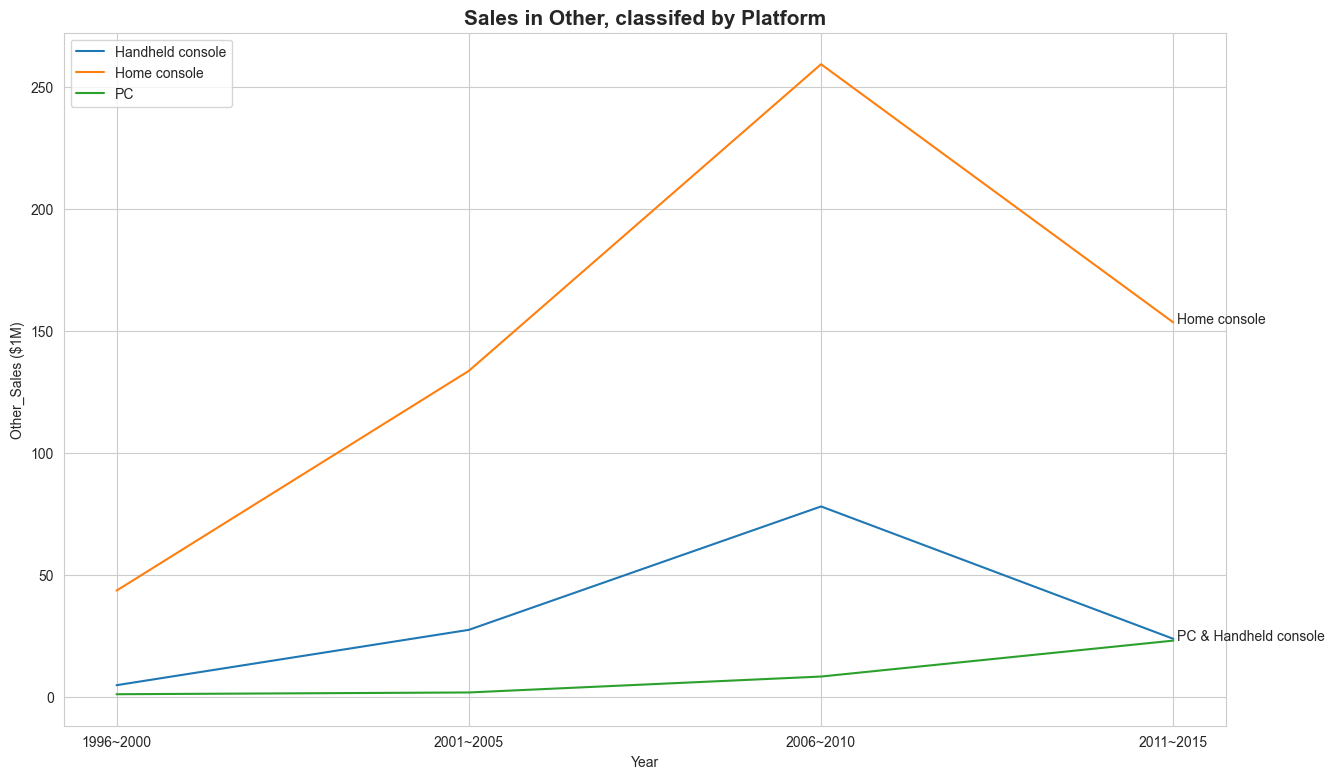

In [1042]:
# 그 외 지역 (Other) 데이터

plt.figure(figsize = (15, 9))
sns.lineplot(data = df_platform_Total, x = 'Year', y = 'Other_Sales ($1M)', hue = 'Platform_Type')
plt.title('Sales in Other, classifed by Platform', fontsize = 15, fontweight = 'bold')
plt.legend(loc = 'upper left')
plt.annotate('Home console', (3.01, 153), fontsize = 10)
plt.annotate('PC & Handheld console', (3.01, 23), fontsize = 10)

---
### 2-4. 지역별 플랫폼별 선호 장르 파악
---

#### 분석 결과

##### - 일본과 글로벌 추세가 다름
    - 글로벌 시장
        - 거치형 콘솔 : Action, Sports, Shooter
        - 휴대형 콘솔 : Action, Role-Playing, Platform
        - PC : Shooter, Role-Playing, Action
    
    - 일본 시장
        - 거치형 콘솔 : Role-Playing, Action, Sports
        - 휴대형 콘솔 : Role-Playing, Misc, Action
        - PC : Role-Playing, Sports, Platform



In [1043]:
# 지역별 플랫폼별 선호 장르 데이터프래임

platform_genre = df.groupby(['Platform_Type', 'Genre'], as_index = False)[['NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)', 'Other_Sales ($1M)', 'Total_Sales ($1M)']].sum()
df_platform_genre = pd.DataFrame(data = platform_genre)
df_platform_genre

,Platform_Type,Genre,NA_Sales ($1M),EU_Sales ($1M),JP_Sales ($1M),Other_Sales ($1M),Total_Sales ($1M)
0,Handheld console,Action,149.31,76.01,51.05,26.56,302.93
1,Handheld console,Adventure,37.41,17.14,21.86,5.09,81.50
2,Handheld console,Fighting,19.81,8.78,13.73,4.40,46.72
3,Handheld console,Misc,87.76,49.57,54.18,12.63,204.14
4,Handheld console,Platform,112.37,58.16,34.80,15.58,220.91
5,Handheld console,Puzzle,47.34,32.67,22.10,7.85,109.96
6,Handheld console,Racing,54.35,32.77,10.01,12.30,109.43
7,Handheld console,Role-Playing,133.53,67.15,179.62,17.87,398.17
8,Handheld console,Shooter,21.62,8.94,1.55,5.17,37.28
9,Handheld console,Simulation,80.15,47.94,30.95,14.07,173.11


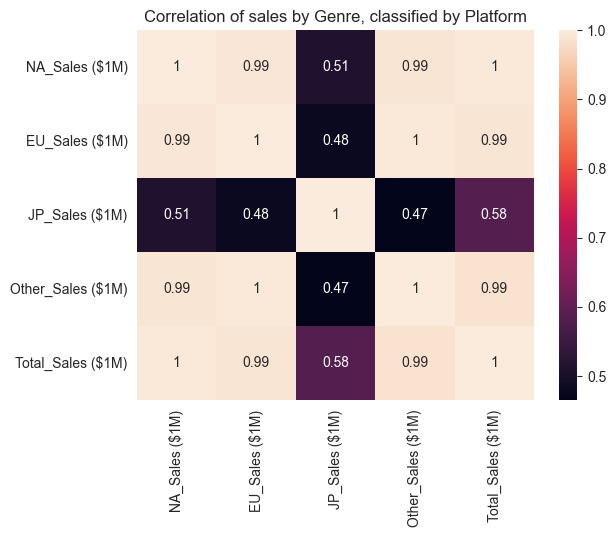

In [1044]:
sns.heatmap(df_platform_genre.iloc[:, -5:].corr(), annot = True)
plt.title('Correlation of sales by Genre, classified by Platform')
plt.show()

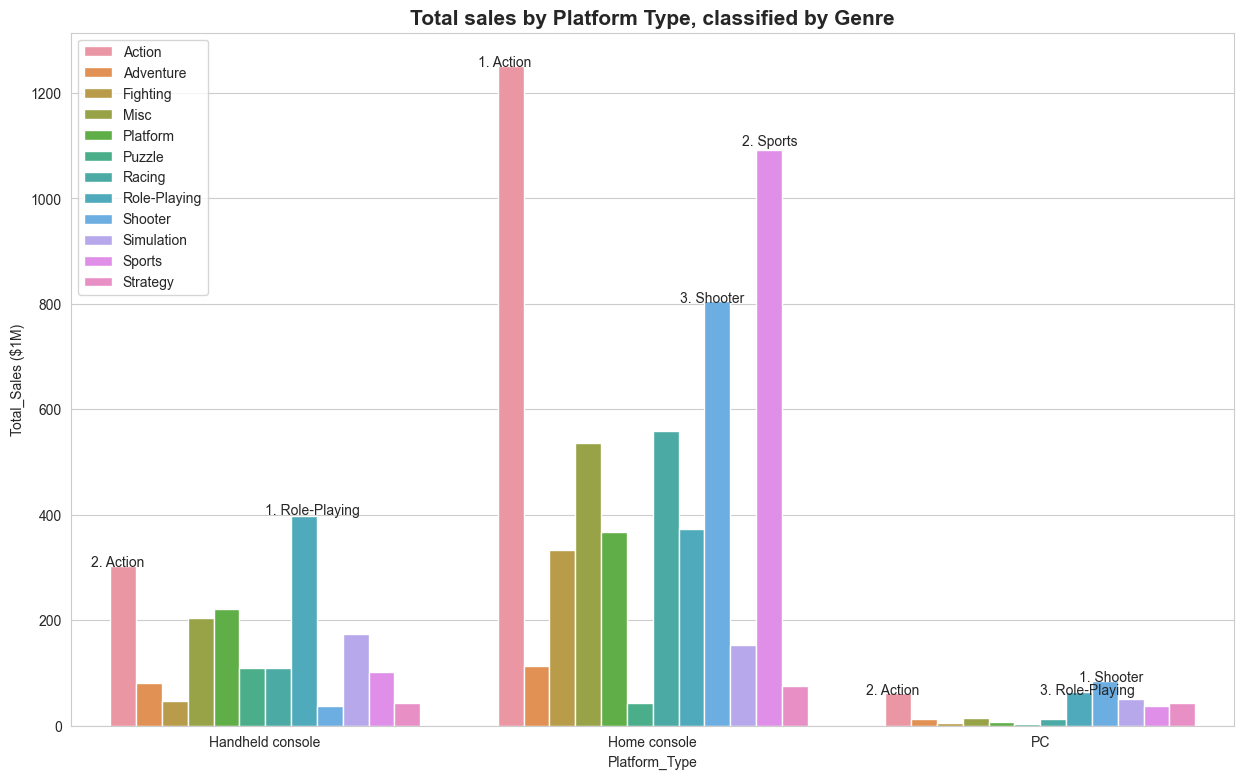

In [1045]:
# 글로벌 플랫폼별 장르 분석

plt.figure(figsize = (15, 9))
sns.barplot(data = df_platform_genre, x = 'Platform_Type', y = 'Total_Sales ($1M)', hue = 'Genre')
plt.title('Total sales by Platform Type, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('2. Action', (-0.45,302))
plt.annotate('1. Role-Playing', (0.,401))
plt.annotate('1. Action', (0.55,1250))
plt.annotate('2. Sports', (1.23,1100))
plt.annotate('3. Shooter', (1.07,802))
plt.annotate('1. Shooter', (2.1,85))
plt.annotate('2. Action', (1.55,60))
plt.annotate('3. Role-Playing', (2,60))
plt.legend(loc = 'upper left')
plt.show()

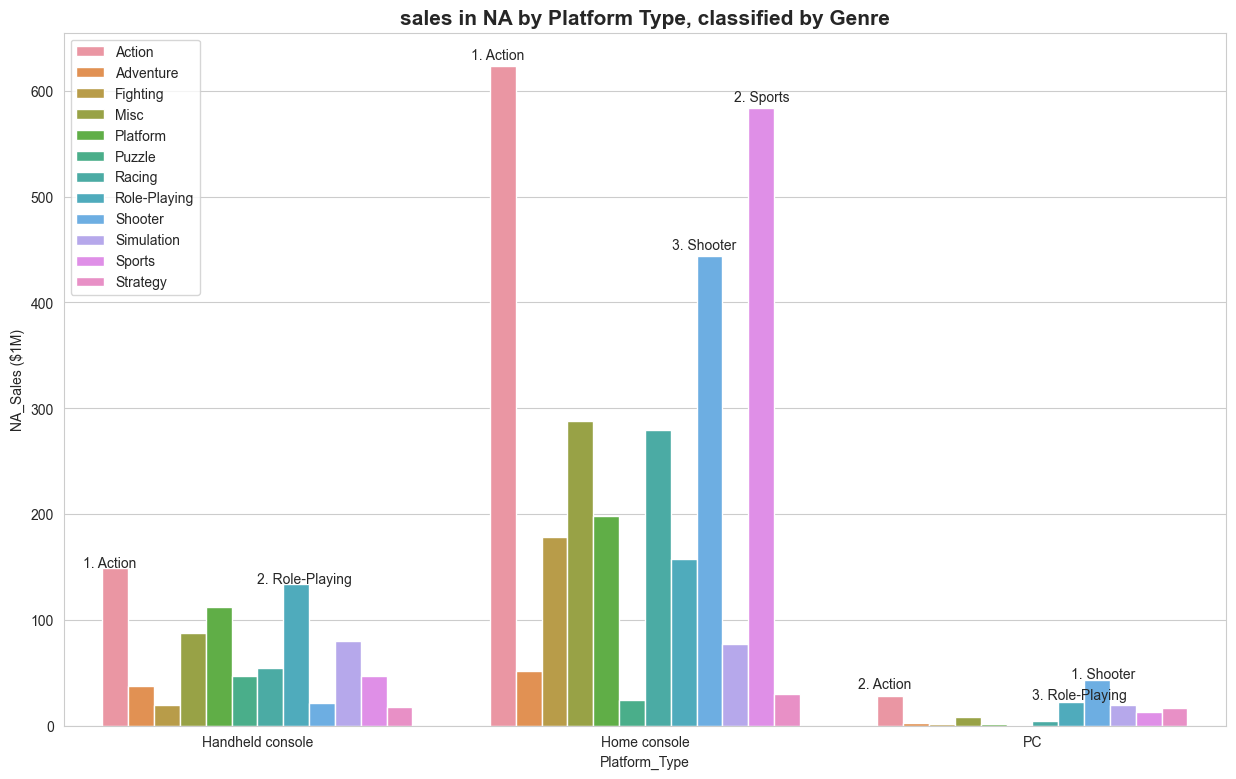

In [1046]:
# 북미 플랫폼, 장르별 매출 분석

plt.figure(figsize = (15, 9))
sns.barplot(data = df_platform_genre, x = 'Platform_Type', y = 'NA_Sales ($1M)', hue = 'Genre')
plt.title('sales in NA by Platform Type, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('1. Action', (-0.45,150))
plt.annotate('2. Role-Playing', (0.,135))
plt.annotate('1. Action', (0.55, 630))
plt.annotate('2. Sports', (1.23, 590))
plt.annotate('3. Shooter', (1.07, 450))
plt.annotate('1. Shooter', (2.1,45))
plt.annotate('2. Action', (1.55,35))
plt.annotate('3. Role-Playing', (2,25))
plt.legend(loc = 'upper left')
plt.show()

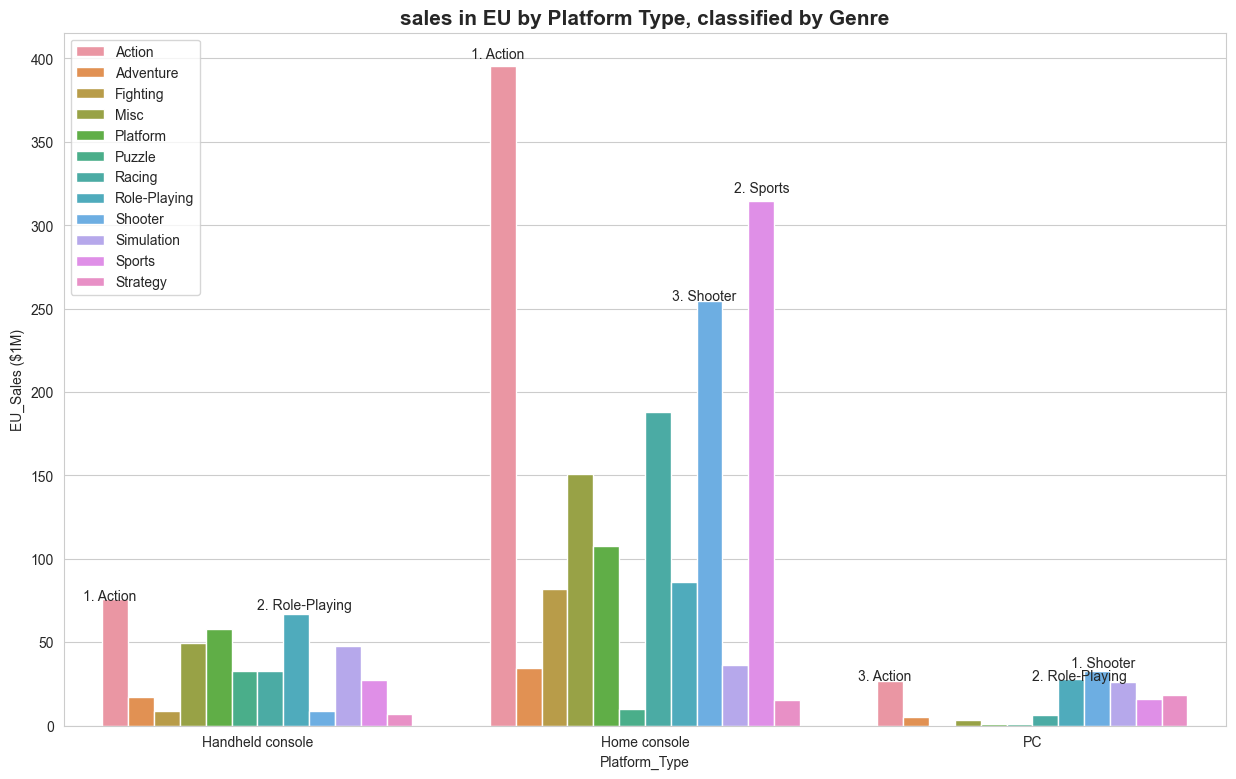

In [1047]:
# 유럽 플랫폼, 장르별 매출 분석

plt.figure(figsize = (15, 9))
sns.barplot(data = df_platform_genre, x = 'Platform_Type', y = 'EU_Sales ($1M)', hue = 'Genre')
plt.title('sales in EU by Platform Type, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('1. Action', (-0.45,75))
plt.annotate('2. Role-Playing', (0.,70))
plt.annotate('1. Action', (0.55, 400))
plt.annotate('2. Sports', (1.23, 320))
plt.annotate('3. Shooter', (1.07, 255))
plt.annotate('1. Shooter', (2.1,35))
plt.annotate('3. Action', (1.55,27))
plt.annotate('2. Role-Playing', (2,27))
plt.legend(loc = 'upper left')
plt.show()

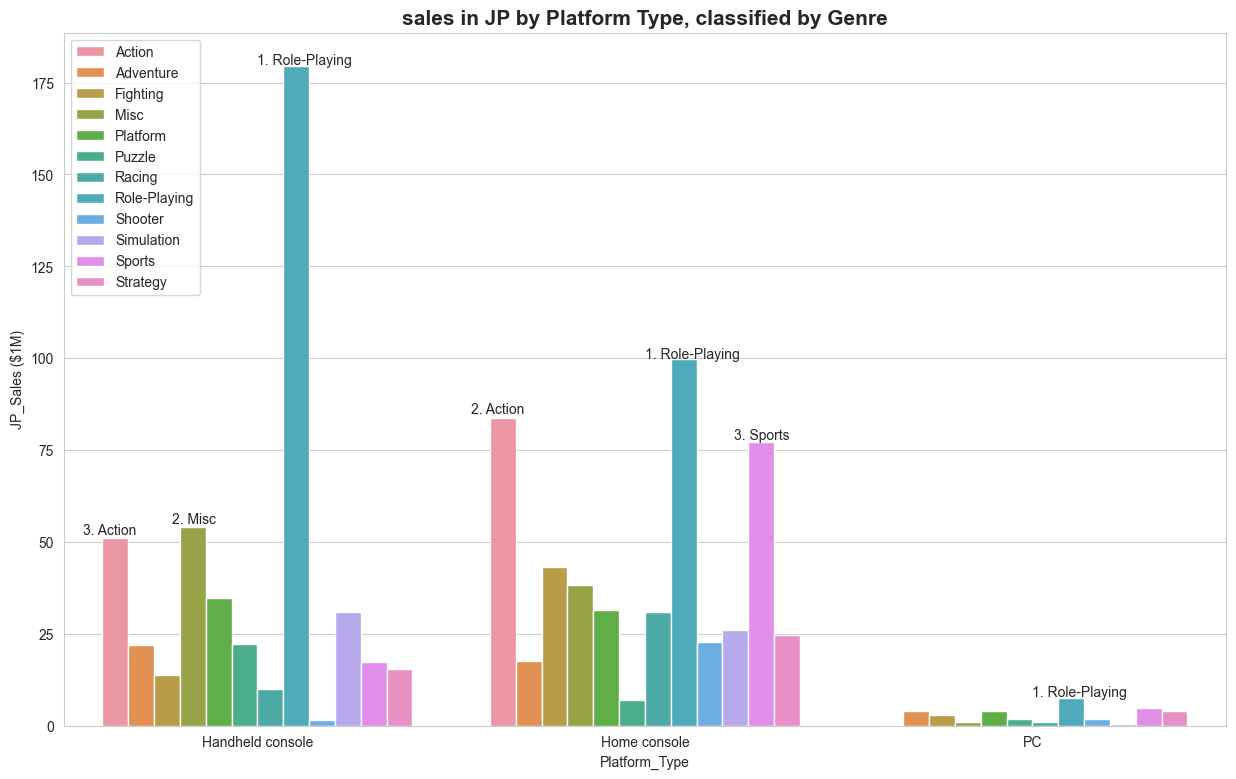

In [1048]:
# 일본 플랫폼, 장르별 매출 분석

plt.figure(figsize = (15, 9))
sns.barplot(data = df_platform_genre, x = 'Platform_Type', y = 'JP_Sales ($1M)', hue = 'Genre')
plt.title('sales in JP by Platform Type, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('3. Action', (-0.45,52))
plt.annotate('1. Role-Playing', (0,180))
plt.annotate('2. Misc', (-0.22, 55))
plt.annotate('2. Action', (0.55, 85))
plt.annotate('1. Role-Playing', (1, 100))
plt.annotate('3. Sports', (1.23, 78))
plt.annotate('1. Role-Playing', (2,8))
plt.legend(loc = 'upper left')
plt.show()

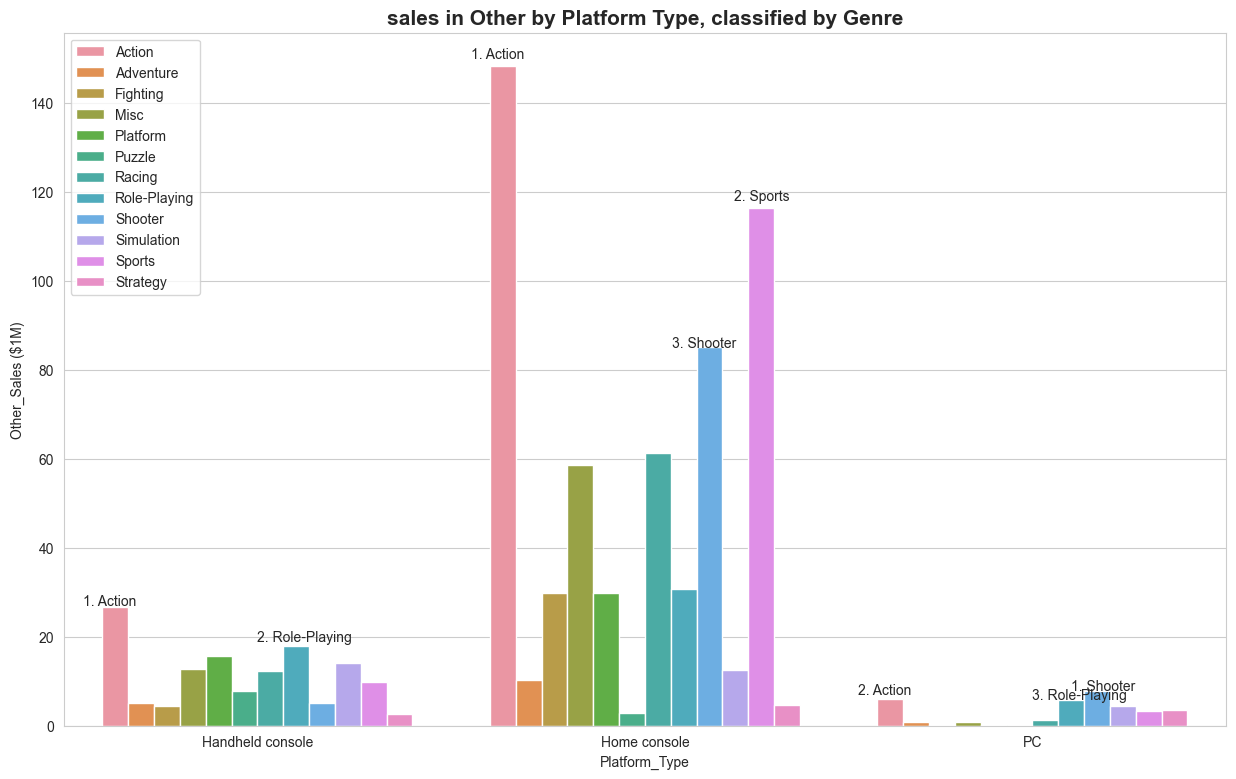

In [1049]:
# 그 외 지역 플랫폼, 장르별 매출 분석

plt.figure(figsize = (15, 9))
sns.barplot(data = df_platform_genre, x = 'Platform_Type', y = 'Other_Sales ($1M)', hue = 'Genre')
plt.title('sales in Other by Platform Type, classified by Genre', fontsize = 15, fontweight = 'bold')
plt.annotate('1. Action', (-0.45,27))
plt.annotate('2. Role-Playing', (0.,19))
plt.annotate('1. Action', (0.55, 150))
plt.annotate('2. Sports', (1.23, 118))
plt.annotate('3. Shooter', (1.07, 85))
plt.annotate('1. Shooter', (2.1,8))
plt.annotate('2. Action', (1.55,7))
plt.annotate('3. Role-Playing', (2,6))
plt.legend(loc = 'upper left')
plt.show()

---
### 2-5. 지역별 인기가 많은 게임
---

In [1050]:
df.columns

Index(['Name', 'Platform', 'Platform_Type', 'Year', 'Genre', 'Publisher',
       'NA_Sales ($1M)', 'EU_Sales ($1M)', 'JP_Sales ($1M)',
       'Other_Sales ($1M)', 'Total_Sales ($1M)'],
      dtype='object')

In [1051]:
def popular_10 (region):
    df_popular = df[['Name', 'Platform', 'Platform_Type', 'Year', 'Genre', 'Publisher', region]].sort_values(by = region, ascending = False).head(5)
    return df_popular

In [1052]:
df_global_popular = popular_10('Total_Sales ($1M)')
df_global_popular

,Name,Platform,Platform_Type,Year,Genre,Publisher,Total_Sales ($1M)
14501,Wii Sports,Wii,Home console,2006,Sports,Nintendo,82.74
7211,Mario Kart Wii,Wii,Home console,2008,Racing,Nintendo,35.83
14503,Wii Sports Resort,Wii,Home console,2009,Sports,Nintendo,33.00
9586,Pokemon Red/Pokemon Blue,GB,Handheld console,1996,Role-Playing,Nintendo,31.38
8856,New Super Mario Bros.,DS,Handheld console,2006,Platform,Nintendo,30.01


In [1053]:
df_NA_popular = popular_10('NA_Sales ($1M)')
df_NA_popular

,Name,Platform,Platform_Type,Year,Genre,Publisher,NA_Sales ($1M)
14501,Wii Sports,Wii,Home console,2006,Sports,Nintendo,41.49
7211,Mario Kart Wii,Wii,Home console,2008,Racing,Nintendo,15.85
14503,Wii Sports Resort,Wii,Home console,2009,Sports,Nintendo,15.75
6234,Kinect Adventures!,X360,Home console,2010,Misc,Microsoft Game Studios,14.97
8859,New Super Mario Bros. Wii,Wii,Home console,2009,Platform,Nintendo,14.59


In [1054]:
df_EU_popular = popular_10('EU_Sales ($1M)')
df_EU_popular

,Name,Platform,Platform_Type,Year,Genre,Publisher,EU_Sales ($1M)
14501,Wii Sports,Wii,Home console,2006,Sports,Nintendo,29.02
7211,Mario Kart Wii,Wii,Home console,2008,Racing,Nintendo,12.88
14503,Wii Sports Resort,Wii,Home console,2009,Sports,Nintendo,11.01
8935,Nintendogs,DS,Handheld console,2005,Simulation,Nintendo,11.00
4755,Grand Theft Auto V,PS3,Home console,2013,Action,Take-Two Interactive,9.27


In [1055]:
df_JP_popular = popular_10('JP_Sales ($1M)')
df_JP_popular

,Name,Platform,Platform_Type,Year,Genre,Publisher,JP_Sales ($1M)
9586,Pokemon Red/Pokemon Blue,GB,Handheld console,1996,Role-Playing,Nintendo,10.22
9573,Pokemon Gold/Pokemon Silver,GB,Handheld console,1999,Role-Playing,Nintendo,7.20
8856,New Super Mario Bros.,DS,Handheld console,2006,Platform,Nintendo,6.50
9571,Pokemon Diamond/Pokemon Pearl,DS,Handheld console,2006,Role-Playing,Nintendo,6.04
9565,Pokemon Black/Pokemon White,DS,Handheld console,2010,Role-Playing,Nintendo,5.65


In [1056]:
df_Other_popular = popular_10('Other_Sales ($1M)')
df_Other_popular

,Name,Platform,Platform_Type,Year,Genre,Publisher,Other_Sales ($1M)
4763,Grand Theft Auto: San Andreas,PS2,Home console,2004,Action,Take-Two Interactive,10.57
14501,Wii Sports,Wii,Home console,2006,Sports,Nintendo,8.46
4730,Gran Turismo 4,PS2,Home console,2004,Racing,Sony Computer Entertainment,7.53
4755,Grand Theft Auto V,PS3,Home console,2013,Action,Take-Two Interactive,4.14
7211,Mario Kart Wii,Wii,Home console,2008,Racing,Nintendo,3.31
